# 🗺️ Mapping Energy Poverty in Alaska

In this notebook, I create a heatmap of energy cost burden across the state of Alaska. These estimates are at the Borough/Census level. Energy cost burden is defined as the ratio of expenditures on space heating and electricity to income.

## 📱 Step 1: Census Data

In this section, I query the US Census API for median household income at the borough/census-area level.

In [5]:
# Import standard packages
import os

# Import third-party packages
import httpx
import polars as pl
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 600

# Import user packages
from src.credentials import USCensusAPI

In [6]:
# Define API Query

## Host Name
host_name = "https://api.census.gov/data/"

## Dataset
dataset = "/acs/acs5"

## Connection
g = "?get="

## Year
year = "2017"

## Variables of Interest (Name and median household income)
var = "NAME,B19013_001E"

## Geography Codes
location = "&for=county:*&in=state:02"

## API Key
api_string = f"{USCensusAPI.api_string}"

## Final Query URL
query_url = f"{host_name}{year}{dataset}{g}{var}{location}{api_string}"

In [7]:
# Retrieve the data and format
response = httpx.get(query_url)
census_data = pl.DataFrame(response.json()).transpose()
census_data = census_data.rename(census_data.head(1).to_dicts().pop()).slice(1)
census_data = (
    census_data.with_columns(
        pl.lit(int(year)).alias("Year"),
        pl.col("B19013_001E").cast(pl.Int64)
    )
    .rename({"B19013_001E": "Median Household Income", "NAME": "Census County Name", "county":"COUNTYFP"})
    .select(pl.col("*").exclude(["state", "county"]))
)
census_data

Census County Name,Median Household Income,COUNTYFP,Year
str,i64,str,i32
"""Aleutians West Census Area, Al…",85192,"""016""",2017
"""Bristol Bay Borough, Alaska""",79500,"""060""",2017
"""Kodiak Island Borough, Alaska""",74167,"""150""",2017
"""Northwest Arctic Borough, Alas…",61533,"""188""",2017
"""Bethel Census Area, Alaska""",53853,"""050""",2017
…,…,…,…
"""Skagway Municipality, Alaska""",70673,"""230""",2017
"""Prince of Wales-Hyder Census A…",52114,"""198""",2017
"""Wrangell City and Borough, Ala…",56094,"""275""",2017


## 📑 Step 2: AHFC Data 

Here I load in the single family residence stats from the 2018 housing assessment. Specifically, they are from the bottom of this URL: https://www.ahfc.us/pros/energy/alaska-housing-assessment/2018-housing-assessment/census-area-energy-characteristics

In [8]:
# Load the AHFC 2018 Housing Assessment Single Family Residence Data
ahfc = pl.read_excel(os.path.join(os.curdir,'data','derived','ahfc_2018_single_family_estimates.xlsx'))
ahfc

Census Area,Space Heating Energy Use (MMBTU),Total Energy Use (MMBTU),Electricity Energy Use (MMBTU),Ratio of Electricity to Total Energy Use,Annual Energy Costs with 2017 Prices,Census County Name
str,f64,f64,f64,f64,i64,str
"""Aleutians East""",98.4,144.1,45.7,0.317141,4285,"""Aleutians East Borough, Alaska"""
"""Aleutians West""",102.1,148.2,46.1,0.311066,5603,"""Aleutians West Census Area, Al…"
"""Anchorage""",200.3,261.9,61.6,0.235204,3368,"""Anchorage Municipality, Alaska"""
"""Bethel Census Area""",94.3,131.3,37.0,0.281797,4659,"""Bethel Census Area, Alaska"""
"""Bristol Bay Borough""",140.7,185.6,44.9,0.241918,4104,"""Bristol Bay Borough, Alaska"""
…,…,…,…,…,…,…
"""Skagway Municipality""",136.1,184.6,48.5,0.26273,4401,"""Skagway Municipality, Alaska"""
"""Valdez-Cordova""",174.4,226.5,52.1,0.230022,5383,"""Valdez-Cordova Census Area, Al…"
"""Wrangell Borough""",160.0,205.6,45.6,0.22179,4512,"""Wrangell City and Borough, Ala…"


## 🕵️‍♂️ Step 3: Merge

Here I merge the median household income from the census data to the AHFC data.

In [9]:
energy_burden = ahfc.join(
    census_data,
    on = "Census County Name",
    how = "left"
)

In [10]:
energy_burden.head(5)

Census Area,Space Heating Energy Use (MMBTU),Total Energy Use (MMBTU),Electricity Energy Use (MMBTU),Ratio of Electricity to Total Energy Use,Annual Energy Costs with 2017 Prices,Census County Name,Median Household Income,COUNTYFP,Year
str,f64,f64,f64,f64,i64,str,i64,str,i32
"""Aleutians East""",98.4,144.1,45.7,0.317141,4285,"""Aleutians East Borough, Alaska""",66607,"""013""",2017
"""Aleutians West""",102.1,148.2,46.1,0.311066,5603,"""Aleutians West Census Area, Al…",85192,"""016""",2017
"""Anchorage""",200.3,261.9,61.6,0.235204,3368,"""Anchorage Municipality, Alaska""",82271,"""020""",2017
"""Bethel Census Area""",94.3,131.3,37.0,0.281797,4659,"""Bethel Census Area, Alaska""",53853,"""050""",2017
"""Bristol Bay Borough""",140.7,185.6,44.9,0.241918,4104,"""Bristol Bay Borough, Alaska""",79500,"""060""",2017


## 💻 Step 4: Energy Burden

Here I divide annual energy expenditures by the median household income.

In [11]:
energy_burden = energy_burden.with_columns(
    (
        pl.col("Annual Energy Costs with 2017 Prices") / pl.col("Median Household Income")
    ).alias("Energy Burden")
)

## 🌐 Step 5: Mapping

In this step, I merge in the massaged data into a GeoJSON produced by the state to generate a heatmap of energy burden ($2017).

In [12]:
map = gpd.read_file(os.path.join(os.curdir,'data','raw','us-census-areas-ak.geojson'))

In [13]:
map = map.merge(energy_burden.to_pandas(), on = "COUNTYFP")

Text(0.5, 1.0, 'Annual Household Energy Burden Estimates (2017)')

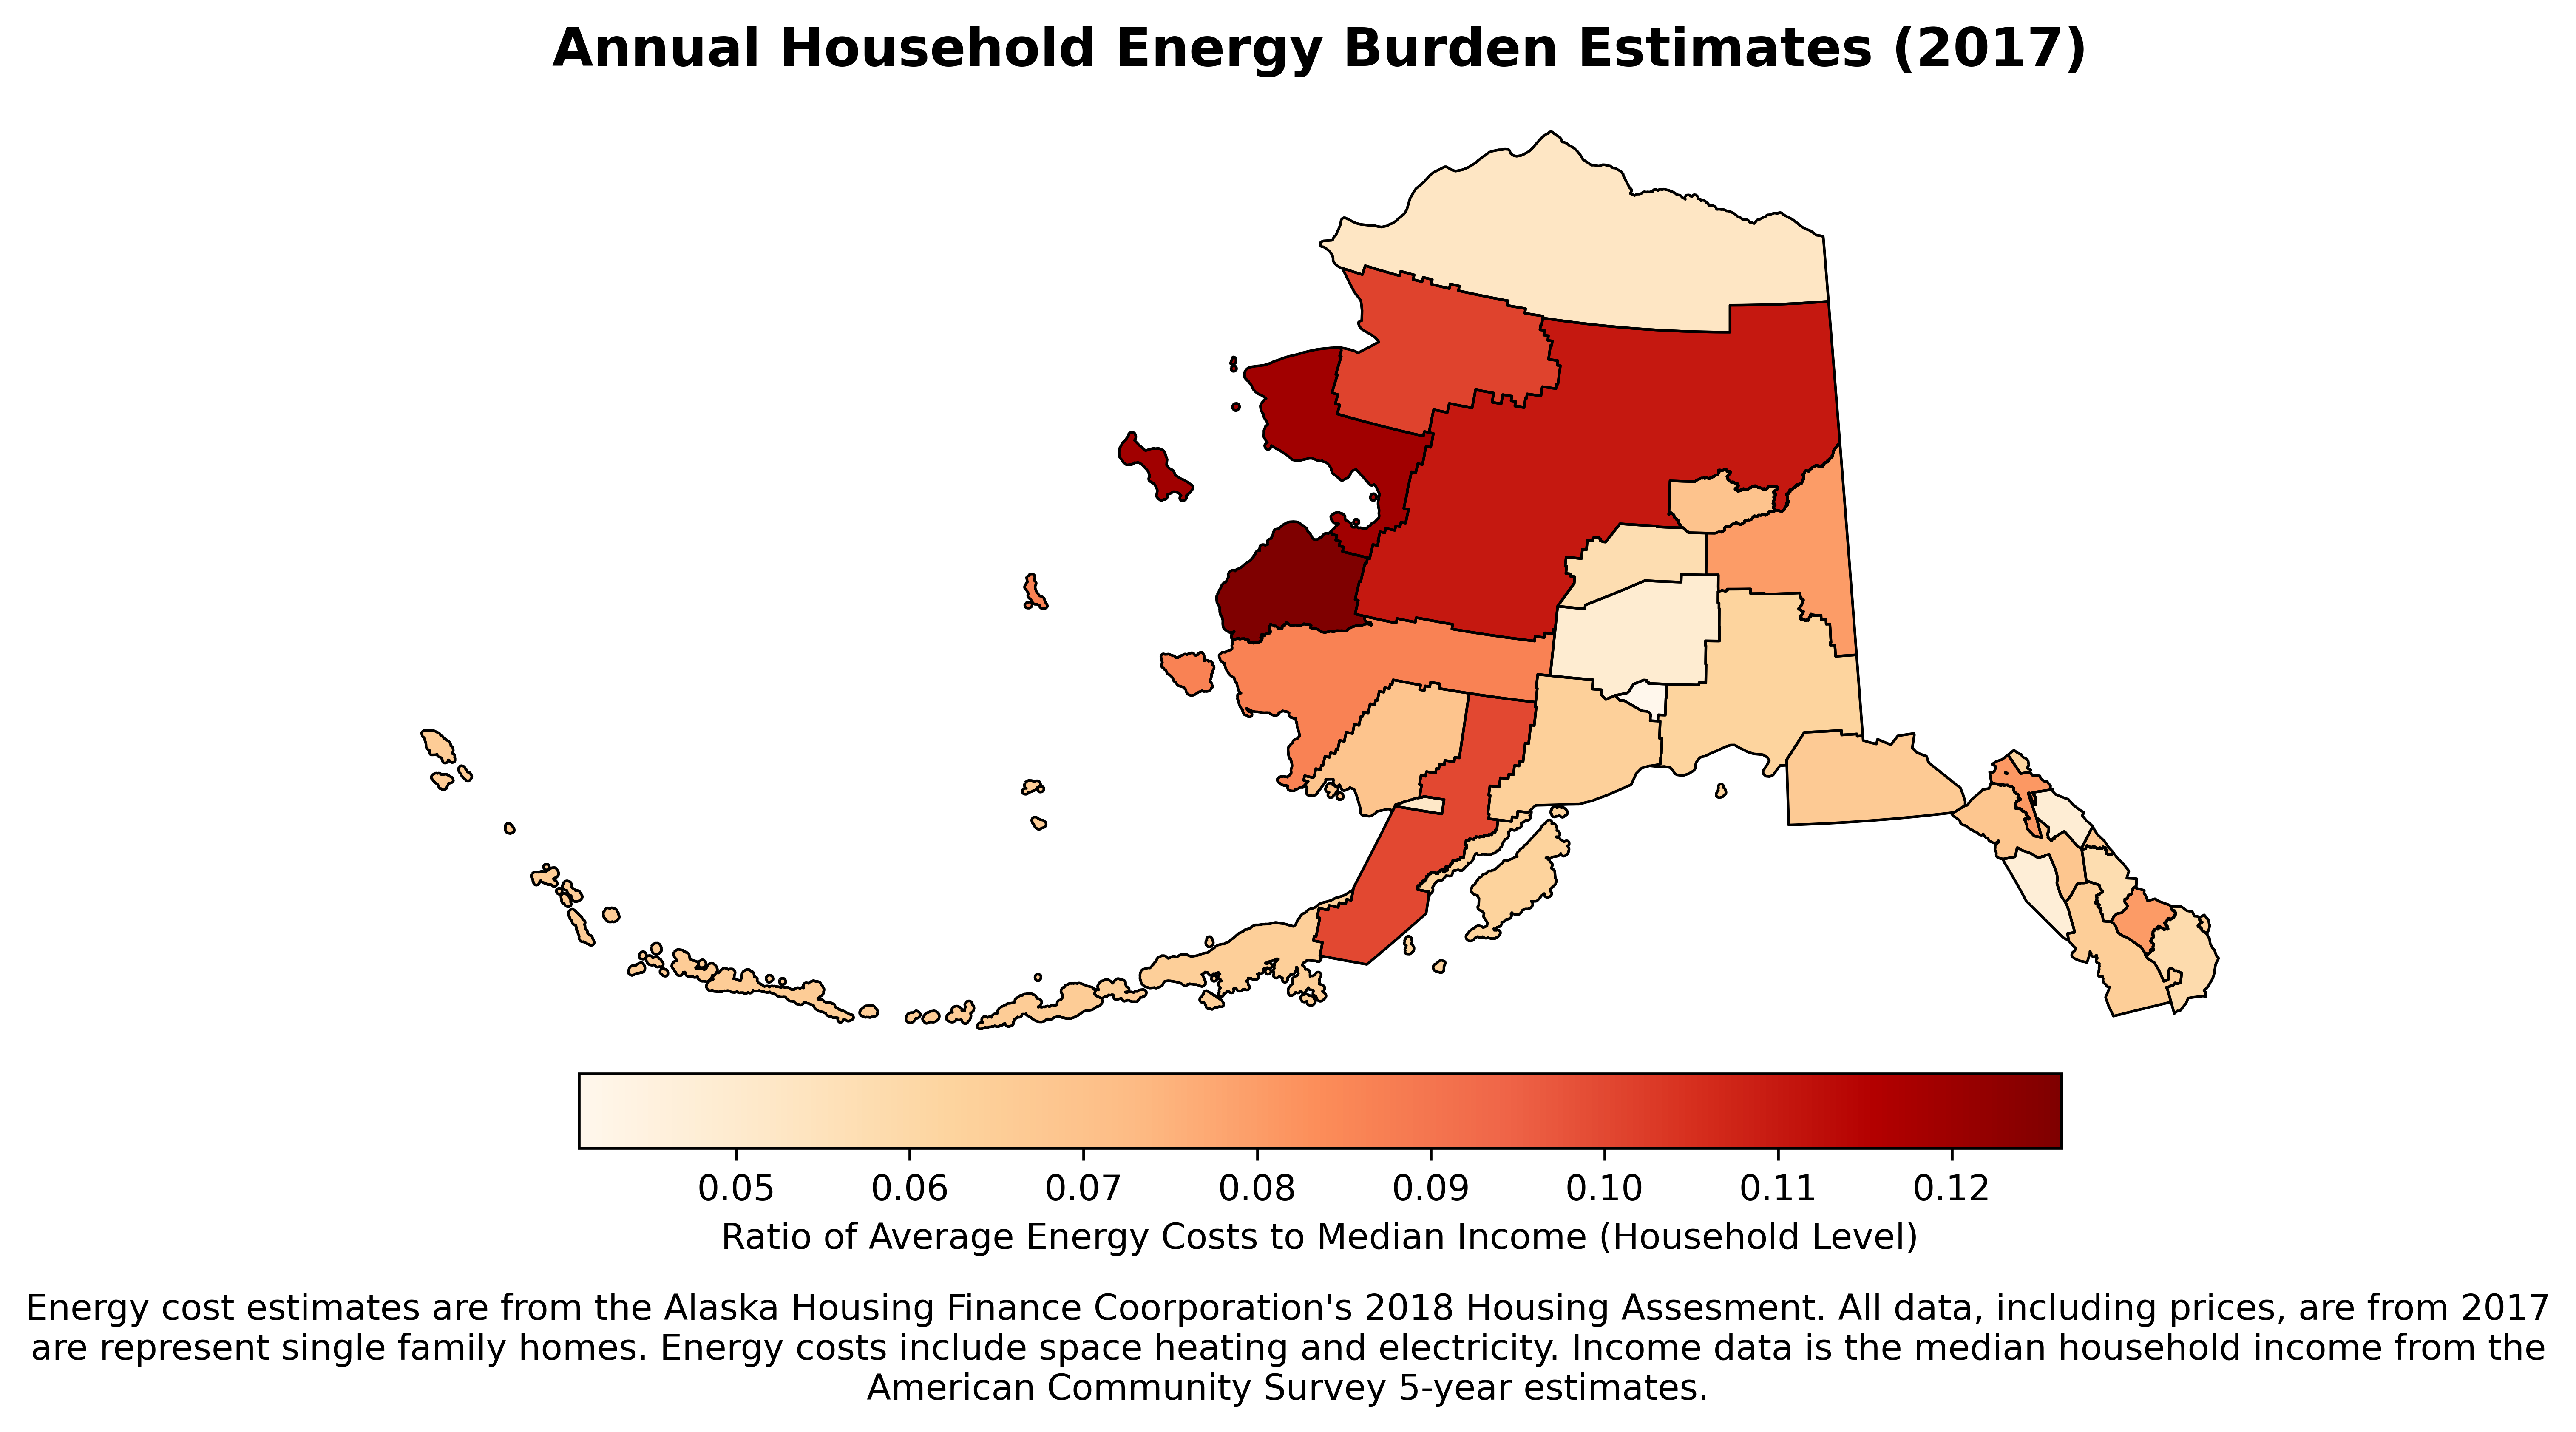

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
map.boundary.plot(ax=ax, edgecolor="black", linewidth=0.75)
map.plot(
    aspect=1,
    column="Energy Burden",
    legend=True,
    cmap="OrRd",
    ax=ax,
    legend_kwds=dict(
        orientation="horizontal",
        pad=0.0,
        shrink=0.75,
        label="Ratio of Average Energy Costs to Median Income (Household Level)",
        fmt="{:.0f}",
    ),
)
txt = "Energy cost estimates are from the Alaska Housing Finance Coorporation's 2018 Housing Assesment. All data, including prices, are from 2017 are represent single family homes. Energy costs include space heating and electricity. Income data is the median household income from the American Community Survey 5-year estimates."
ax.set_axis_off()
fig.text(0.5, 0.1, txt, ha="center", wrap=True)
plt.title(
    "Annual Household Energy Burden Estimates (2017)", fontsize=15, fontweight="bold"
)